In [1]:
# dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nfx.lm.gibbs
import nfx.mlm.custom
import nfx.misc.plot

In [2]:
# spaghetti

def sample_chain(response, covariates, graph, pr_free, seeds, n_samples, n_warmup, rng, init=None):

    weights = np.where(seeds < pr_free, 1, np.inf)
    sampler = nfx.mlm.custom.sample_posterior(response.values, covariates.values, graph, prior_n_eta=weights, init=init, ome=rng)
    samples = [next(sampler)[:-1] for _ in range(n_warmup + n_samples)][n_warmup:]
    return summarize_samples(response.values, covariates.values, samples, pr_free, weights)

def summarize_samples(y, x, samples, pr_free, weights):

    loglik_samples = np.array([np.sum(
        np.where(np.isinf(weights), (np.log(lam_) - np.log(2 * np.pi) - lam_ * np.square(y - bet_[0] @ x.T)) / 2, np.log(lam_) - np.log(np.pi) - np.log(1 + lam_ * np.square(y - bet_[0] @ x.T))))
        for bet_, _, lam_ in samples])
    df = pd.DataFrame(loglik_samples[np.newaxis], index=['log_likelihood'])
    df.index = df.index.rename('summary')
    df.columns = df.columns.rename('iter')
    df['pr_free'] = pr_free
    df = df.reset_index().set_index(['pr_free', 'summary'])
    return df

def package_samples(samples, node_names, covariate_names):

    loc_samples, scale_samples, resid_samples = zip(*samples)
    loc_samples = [np.array(loc_samples_) for loc_samples_ in zip(*loc_samples)][::-1]
    scale_samples = np.trace(scale_samples, axis1=2, axis2=3).T[::-1]
    resid_samples = np.array(resid_samples)[np.newaxis]
    return package_loc_samples(loc_samples, node_names, covariate_names), package_scale_samples(scale_samples), package_resid_samples(resid_samples, ['x'])

def package_loc_samples(loc_samples, node_names, covariate_names):

    dfs = []
    for i, (loc_samples_, node_names_) in enumerate(zip(loc_samples, node_names)):
        for j, node_names__ in enumerate(node_names_):
            df_ = pd.DataFrame(loc_samples_[:, j].T, index=covariate_names)
            df_.index = df_.index.rename('covariate')
            df_.columns = df_.columns.rename('iter')
            df_['level'] = i
            df_['node'] = node_names__.zfill(i + 1)
            dfs.append(df_)
    df = pd.concat(dfs).reset_index().set_index(['level', 'node', 'covariate'])
    return df

def package_scale_samples(scale_samples):

    df = pd.DataFrame(scale_samples, index=np.arange(len(scale_samples)))
    df.index = df.index.rename('level')
    df.columns = df.columns.rename('iter')
    df = df.reset_index().set_index(['level'])
    return df

def package_resid_samples(resid_samples, node_names):

    df = pd.DataFrame(np.mean(resid_samples, 0)[np.newaxis], index=['mean'])
    df.index = df.index.rename('node')
    df.columns = df.columns.rename('iter')
    df = df.reset_index().set_index(['node'])
    return df
        
def est_acf(samples, n_lags):

    acf = samples.apply(lambda x: nfx.misc.plot.est_acf(x.values, n_lags), 1, False, 'expand')
    acf.columns = acf.columns.rename('lag')
    return acf

def est_ess(acfs, titer):
    
    df = pd.DataFrame(index=acfs.index)
    df['iat[iter]'] = acfs.apply(lambda x: nfx.misc.plot.est_int_autocor(x.values), 1, False, 'expand').rename('iat')
    df['iat[sec]'] = df['iat[iter]'] * titer
    df['rate[iter]'] = 1 / (2 * df['iat[iter]'])
    df['rate[sec]'] = df['rate[iter]'] / titer
    return df

In [3]:
# config

factor_names = ['housing']
rng = np.random.default_rng(0)
n_samples = 10000
n_warmup = 100

In [4]:
# load data

macro = pd.read_csv('demos/data/sareb_covariates.csv').set_index('time')
prices = pd.read_csv('demos/data/sareb_prices_synthetic.csv').set_index('zip')

In [5]:
# format response

response = prices.diff(axis=1).dropna(axis=1)

In [6]:
# format covariates

covariates = macro.loc[:, factor_names]
covariates['_constant'] = 1
covariates['_trend'] = np.arange(covariates.shape[0])
covariates = covariates.loc[:, ['_trend', 'housing']].diff().dropna().loc[response.columns]

In [7]:
# construct graph

indices = response.index.to_frame()
indices['lvl_1'] = indices.zip.str.slice(0, 2)
indices['lvl_2'] = indices.zip.str.slice(0, 3)
indices['lvl_3'] = indices.zip.str.slice(0, 4)
indices['lvl_4'] = indices.zip.str.slice(0, 5)
indices = indices.drop('zip', 1)
codes = indices.apply(lambda x: x.astype('category').cat.codes).astype('int64')
n_nodes = codes.max(0) + 1
parent_node_3 = codes[['lvl_4', 'lvl_3']].drop_duplicates().lvl_3
parent_node_2 = codes[['lvl_3', 'lvl_2']].drop_duplicates().lvl_2
parent_node_1 = codes[['lvl_2', 'lvl_1']].drop_duplicates().lvl_1
node_names = [['0'], indices.lvl_1.unique(), indices.lvl_2.unique(), indices.lvl_3.unique(), indices.lvl_4.unique()]
graph = [parent_node_3.values, parent_node_2.values, parent_node_1.values]

/tmp/ipykernel_4634/1268562597.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  indices = indices.drop('zip', 1)


In [8]:
# conduct experiments

seeds = rng.uniform(size=response.values.shape)
samples = [sample_chain(response, covariates, graph, pr, seeds, n_samples, n_warmup, rng) for pr in np.linspace(0, 1, 11)]

In [9]:
df_samples = pd.concat(samples)
df_acf = est_acf(df_samples, 64).rename_axis(columns='lag')
df_ess = est_ess(df_acf, 1)

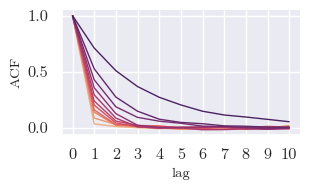

In [4]:
sns.relplot(data=df_acf.iloc[:, :11].stack().rename('value').reset_index(), x='lag', y='value', hue='pr_free', kind='line', aspect=8/5, height=2, legend=False, palette=sns.color_palette('flare', as_cmap=True), linewidth=1)
plt.ylabel('ACF')